In [1]:
cd ~/work/waroncars

/media/wintermute/work/waroncars


In [2]:
plt = plotter()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
import kalman

In [4]:
def norm_sum(x):
    s = x.cumsum()
    return s/s[-1]

In [5]:
def make_hline(ax, y=0):
    ax.hlines(y, *ax.get_xlim(), linestyle='--', linewidth=1, color='black')

In [6]:
def std_diag(Σ):
    return np.sqrt(np.diag(Σ))

In [7]:
def gen_kalman(kal, time, path):
    for i, (t, z) in enumerate(zip(time, path)):
        if i == 0:
            x, P = kal.start(z)
            t0 = t
        else:
            dt = t - t0
            yield kal.predict(x, P, dt=dt)
            x, P = kal.update(x, P, z, dt=dt)
            t0 = t

In [8]:
names0 = ['x', 'y', 'w', 'h']
names = names0 + [f'v{c}' for c in names0]
namesσ0 = [f'σ{c}' for c in names0]
namesσ = [f'σ{c}' for c in names]
marker = dict(marker='o', markersize=3)

## Generate Path

In [9]:
# path params
N = 100
zϵ = np.array([10, 10, 5, 5])
z0 = np.array([100, 200, 100, 50])
z1 = np.array([600, 400, 110, 40])

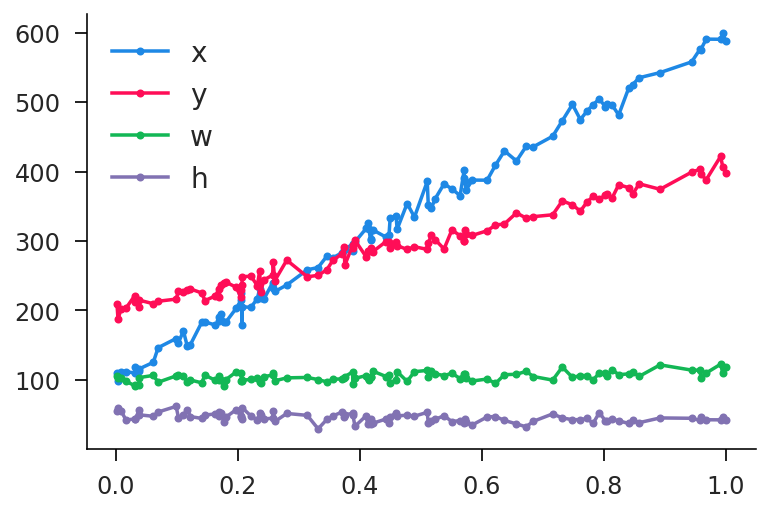

In [10]:
# generate path
# t_path = np.linspace(0, 1, N)
t_path = norm_sum(np.random.exponential(1/N, size=N))
z_path = (1-t_path[:, None])*z0[None, :] + t_path[:, None]*z1[None, :]
z_obs = z_path + zϵ[None, :]*np.random.randn(N, 4)
df_obs = pd.DataFrame(z_obs, columns=names0, index=t_path)
df_obs.plot(**marker);

## Run Filter

In [11]:
# kalman setup
nd = 4
σx = np.array([10, 10, 5, 5])
σv = np.array([100, 100, 10, 10])
k = kalman.KalmanTracker(nd, σx, σv)

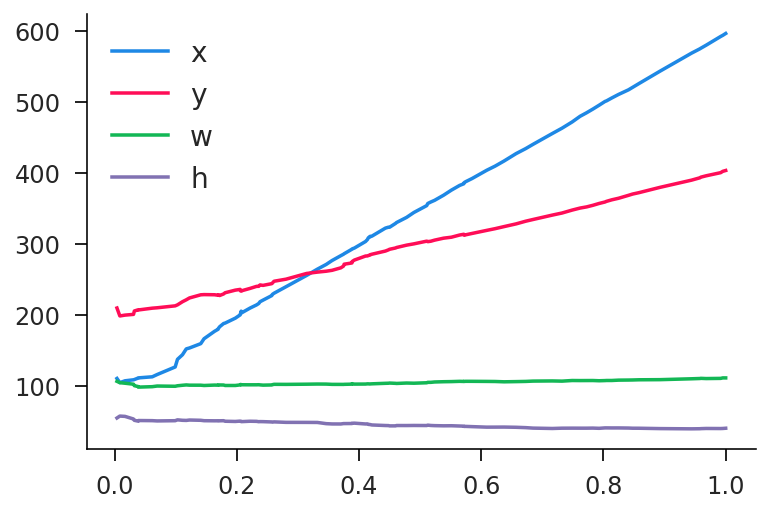

In [12]:
z_pred = np.vstack([
    np.hstack([x, std_diag(P)]) for x, P in gen_kalman(k, t_path, z_obs)
])
df_pred = pd.DataFrame(z_pred[:, :8], columns=names, index=t_path[1:])
df_sigma = pd.DataFrame(z_pred[:, 8:], columns=names, index=t_path[1:])
df_pred[names0].plot();

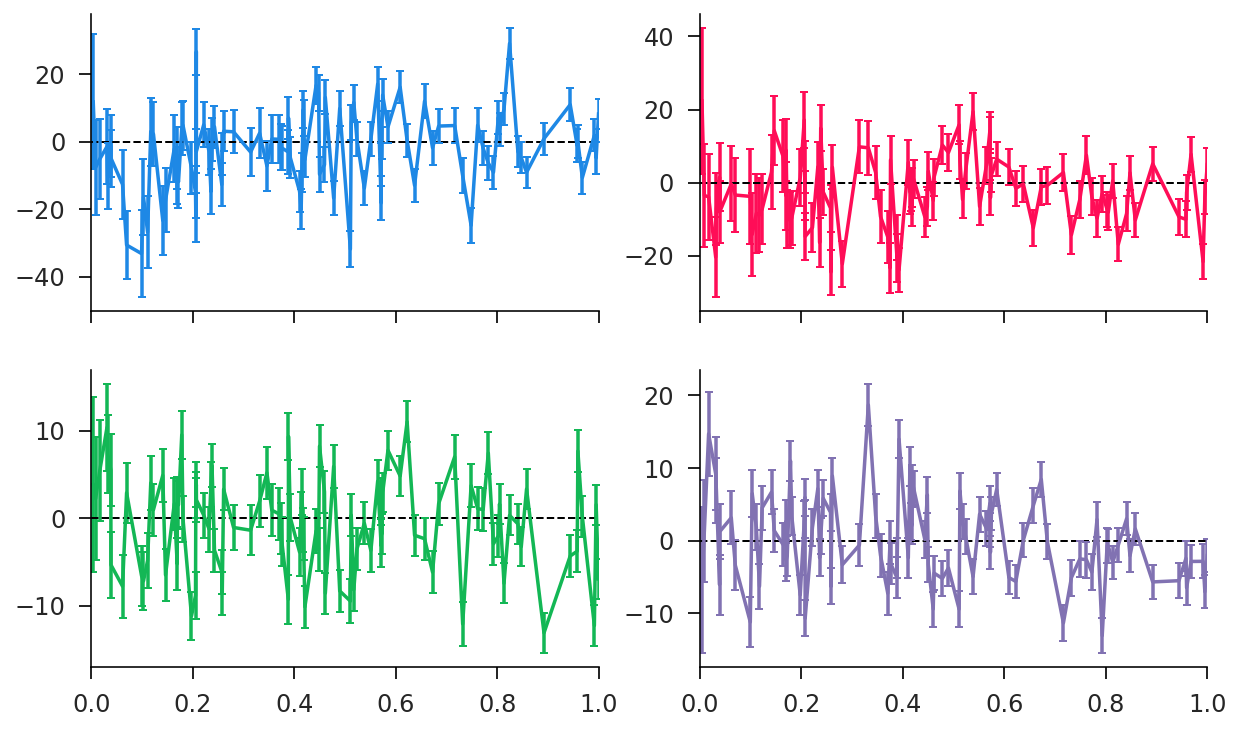

In [13]:
df_err = (df_pred[names0] - df_obs).dropna()
yerr = 2*df_sigma[names0].values.T
axs = df_err.plot(yerr=yerr, subplots=True, layout=(2, 2), figsize=(10, 6), legend=False, capsize=2)
for ax in axs.flatten():
    ax.set_xlim(0, 1)
    make_hline(ax)

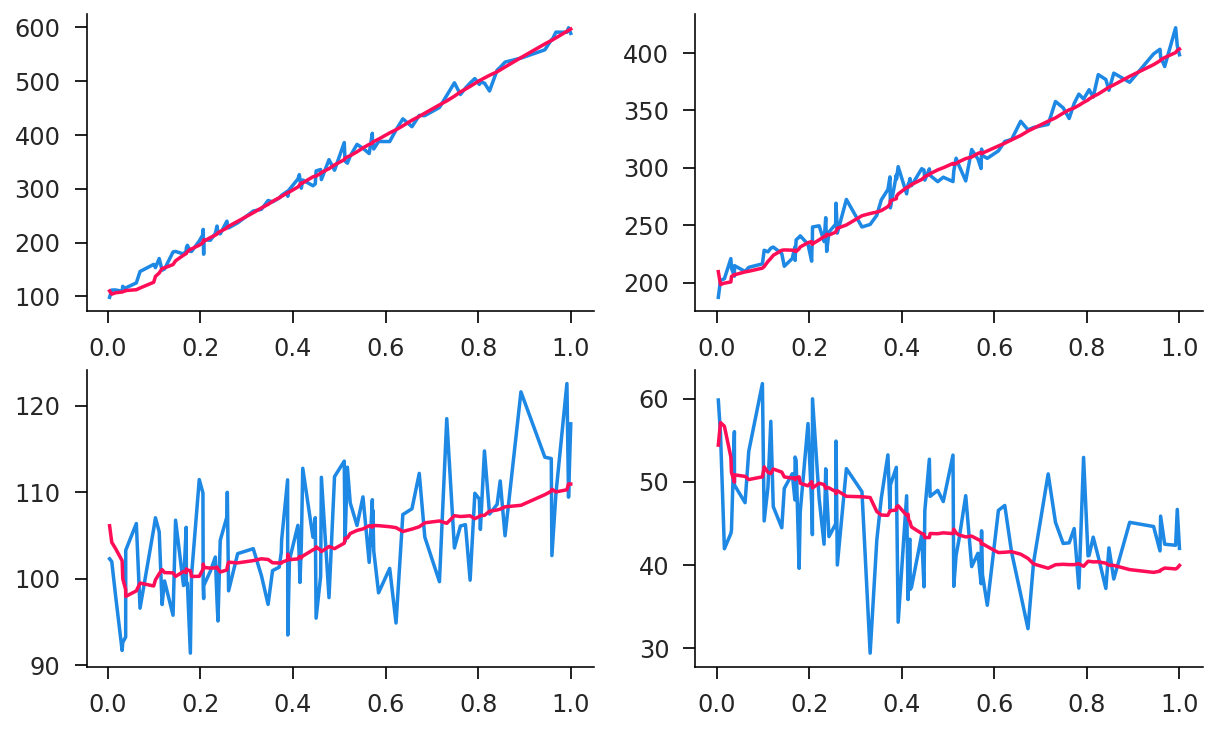

In [14]:
df_joint = pd.concat([
    df_obs.add_suffix('_obs'),
    df_pred[names0].add_suffix('_pred'),
], axis=1).dropna()
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for c, ax in zip(names0, ax.flatten()):
    df_joint[[f'{c}_obs', f'{c}_pred']].plot(ax=ax, legend=False)